11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - critic_loss: -57.2304 - generator_loss: -169.1243
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 32ms/step - critic_loss: -188.5135 - generator_loss: -603.1052
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - critic_loss: -145.2296 - generator_loss: -733.8557
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - critic_loss: -107.5287 - generator_loss: -898.4487
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - critic_loss: -182.4166 - generator_loss: -994.6678
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - critic_loss: -309.0389 - generator_loss: -96.5424
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - critic_loss: -215.0516 - generator_loss: -2456.7014
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - critic_loss: -228.8484 - generator_loss: -2714.2158
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - critic_loss: -375.4642 - generator_loss: -961.6389
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━

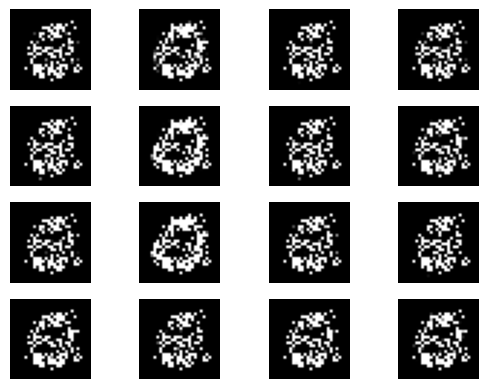

In [1]:
# WGAN_mnist.py
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)

# Generator Model
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(100,)),
        layers.Dense(256, activation="relu"),
        layers.Dense(28 * 28 * 1, activation="tanh"),
        layers.Reshape((28, 28, 1))
    ])
    return model

# Critic Model
def build_critic():
    model = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(1)
    ])
    return model

# WGAN Loss (Wasserstein Loss)
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

# Training Step for WGAN
class WGAN(tf.keras.Model):
    def __init__(self, generator, critic, noise_dim):
        super(WGAN, self).__init__()
        self.generator = generator
        self.critic = critic
        self.noise_dim = noise_dim

    def compile(self, generator_optimizer, critic_optimizer):
        super(WGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.critic_optimizer = critic_optimizer

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, self.noise_dim])
        generated_images = self.generator(noise)

        # Critic training
        with tf.GradientTape() as tape:
            real_output = self.critic(real_images)
            fake_output = self.critic(generated_images)
            critic_loss = wasserstein_loss(tf.ones_like(real_output), real_output) + \
                          wasserstein_loss(-tf.ones_like(fake_output), fake_output)
        critic_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

        # Generator training
        noise = tf.random.normal([batch_size, self.noise_dim])
        with tf.GradientTape() as tape:
            generated_images = self.generator(noise)
            fake_output = self.critic(generated_images)
            generator_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)
        generator_gradients = tape.gradient(generator_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))

        return {"critic_loss": critic_loss, "generator_loss": generator_loss}

# Create models
generator = build_generator()
critic = build_critic()
wgan = WGAN(generator, critic, noise_dim=100)

# Compile and Train WGAN
wgan.compile(
    generator_optimizer=tf.keras.optimizers.Adam(1e-4),
    critic_optimizer=tf.keras.optimizers.Adam(1e-4)
)

wgan.fit(train_images, epochs=50, batch_size=64)

# Generate images after training
noise = tf.random.normal([16, 100])
generated_images = generator(noise)
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
    plt.axis('off')
plt.show()
